In [1]:
from ast import Index
import pandas as pd
import numpy as np
import sklearn.tree
import sklearn.ensemble
import sklearn.metrics
import sklearn.inspection
import graphviz
import plotly.express as px
import fastbook
from ucimlrepo import fetch_ucirepo
from treeinterpreter import treeinterpreter


In [2]:
df_white = pd.read_csv('winequality-white_NO_ALCOHOL.csv', sep=';')
df_red = pd.read_csv('winequality-red_NO_ALCOHOL.csv', sep=';')

total_missing_values_white = df_white.isna().sum().sum()
total_missing_values_red = df_red.isna().sum().sum()

print("Total missing values in the DataFrame (white):", total_missing_values_white)
print("Total missing values in the DataFrame (red):", total_missing_values_red)

Total missing values in the DataFrame (white): 0
Total missing values in the DataFrame (red): 0


In [3]:
train_df, val_df = sklearn.model_selection.train_test_split(df_red, 
    test_size=0.2)

train_X, train_y = train_df.drop(['quality'], axis = 1), train_df.quality
val_X, val_y = val_df.drop(['quality'], axis = 1), val_df.quality

print(train_X.shape, val_X.shape)

model = sklearn.tree.DecisionTreeRegressor(max_depth=3)

model.fit(train_X, train_y)

(1279, 10) (320, 10)


DecisionTreeRegressor(max_depth=3)

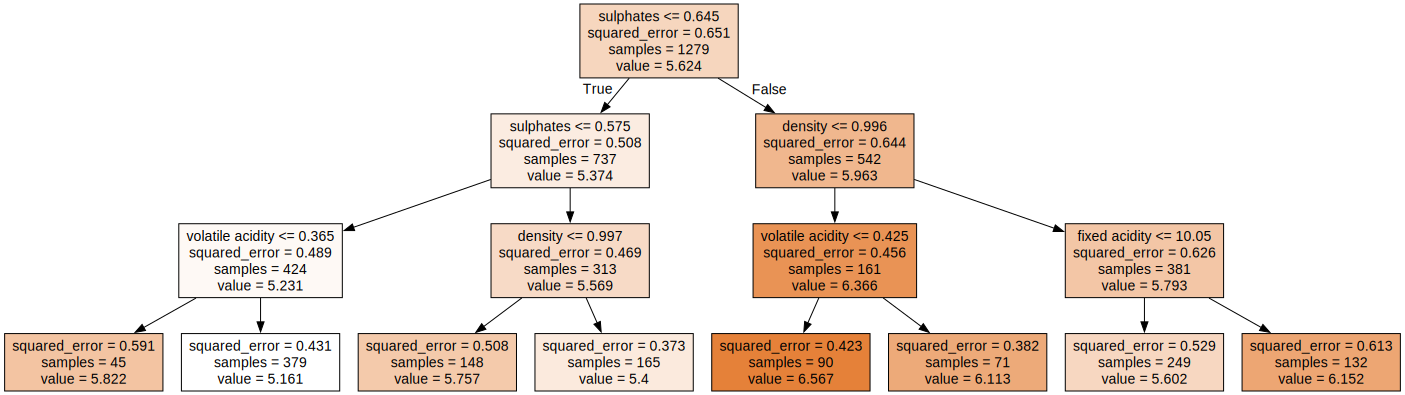

In [4]:
graphviz_path = 'C:\\Program Files\\Graphviz\\bin'  

graph = graphviz.Graph(engine='dot', directory=graphviz_path)

dot_data = sklearn.tree.export_graphviz(model, out_file=None,
                                       feature_names = train_X.columns,
                                       filled = True)

graph = graphviz.Source(dot_data)
 
png_bytes = graph.pipe(format='png')
with open('decision_tree.png','wb') as f:
    f.write(png_bytes)

graph

In [5]:
def get_binary_split_for_param(param, X, y):
    uniq_vals = list(sorted(X[param].unique()))
    
    tmp_data = []
    
    for i in range(1, len(uniq_vals)):
        threshold = 0.5 * (uniq_vals[i-1] + uniq_vals[i])
         
        # split dataset by threshold
        split_left = y[X[param] <= threshold]
        split_right = y[X[param] > threshold]
        
        # calculate predicted values for each split
        pred_left = split_left.mean()
        pred_right = split_right.mean()

        num_left = split_left.shape[0]
        num_right = split_right.shape[0]

        mse_left = ((split_left - pred_left) * (split_left - pred_left)).mean()
        mse_right = ((split_right - pred_right) * (split_right - pred_right)).mean()
        mse = mse_left * num_left / (num_left + num_right) \
            + mse_right * num_right / (num_left + num_right)

        tmp_data.append(
            {
                'param': param,
                'threshold': threshold,
                'mse': mse
            }
        )
            
    return pd.DataFrame(tmp_data).sort_values('mse')

get_binary_split_for_param('sulphates', train_X, train_y).head(5)


,param,threshold,mse
25,sulphates,0.645,0.565991
23,sulphates,0.625,0.567248
24,sulphates,0.635,0.567833
19,sulphates,0.585,0.568131
22,sulphates,0.615,0.568936


In [6]:
def get_binary_split(X, y):
    tmp_dfs = []
    for param in X.columns:
        tmp_dfs.append(get_binary_split_for_param(param, X, y))
        
    return pd.concat(tmp_dfs).sort_values('mse')

get_binary_split(train_X, train_y).head(5)

,param,threshold,mse
25,sulphates,0.645,0.565991
23,sulphates,0.625,0.567248
24,sulphates,0.635,0.567833
19,sulphates,0.585,0.568131
22,sulphates,0.615,0.568936


In [7]:
model = sklearn.tree.DecisionTreeRegressor(min_samples_leaf = 420)
model.fit(train_X, train_y)

print(sklearn.metrics.mean_absolute_error(model.predict(val_X), val_y))

0.6192552991082827


In [8]:
model = sklearn.ensemble.RandomForestRegressor(100, min_samples_leaf=100)
model.fit(train_X, train_y)

print(sklearn.metrics.mean_absolute_error(model.predict(val_X), val_y))

0.5618934821788896


In [9]:
model = sklearn.ensemble.RandomForestRegressor(100, min_samples_leaf=100, 
     oob_score=True)

model.fit(train_X, train_y)

print(sklearn.metrics.mean_absolute_error(model.predict(val_X), val_y))

print(sklearn.metrics.mean_absolute_error(model.predict(train_X), train_y))

print(sklearn.metrics.mean_absolute_error(model.oob_prediction_, train_y))

0.5615811837487603
0.5310446248042444
0.5451107524650866


In [10]:
def plot_feature_importance(model, names, threshold = None):
    feature_importance_df = pd.DataFrame.from_dict({'feature_importance': model.feature_importances_,
                                                    'feature': names})\
            .set_index('feature').sort_values('feature_importance', ascending = False)

    if threshold is not None:
        feature_importance_df = feature_importance_df[feature_importance_df.feature_importance > threshold]

    fig = px.bar(
        feature_importance_df,
        text_auto = '.2f',
        labels = {'value': 'feature importance'},
        title = 'Feature importances'
    )

    fig.update_layout(showlegend = False)
    fig.show()
    return feature_importance_df

In [11]:
feature_importance_df = plot_feature_importance(model, train_X.columns)

val_df['predictions_mean'] = np.stack([dt.predict(val_X.values) 
  for dt in model.estimators_]).mean(axis = 0)
val_df['predictions_std'] = np.stack([dt.predict(val_X.values) 
  for dt in model.estimators_]).std(axis = 0)



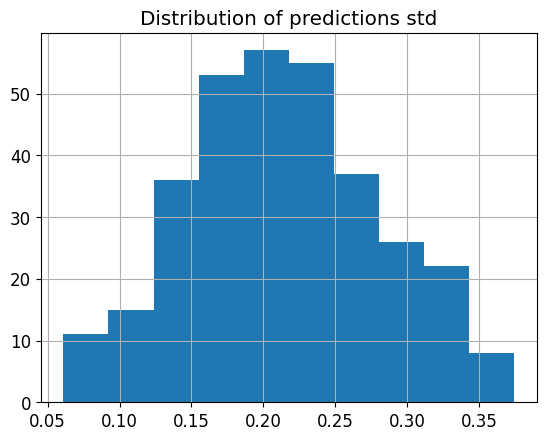

In [12]:
ax = val_df.predictions_std.hist(bins = 10)
ax.set_title('Distribution of predictions std')

row = val_X.iloc[[7]]
prediction, bias, contributions = treeinterpreter.predict(model, row.values)



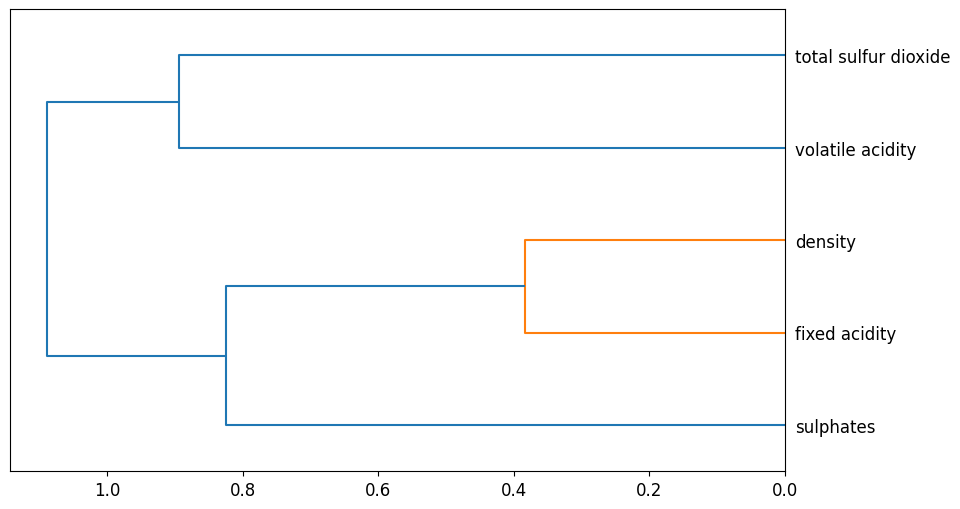

In [13]:
low_impact_features = feature_importance_df[feature_importance_df.feature_importance <= 0.01].index.values

train_X_imp = train_X.drop(low_impact_features, axis = 1)
val_X_imp = val_X.drop(low_impact_features, axis = 1)

model_imp = sklearn.ensemble.RandomForestRegressor(100, min_samples_leaf=100)
model_imp.fit(train_X, train_y)

fastbook.cluster_columns(train_X_imp)

In [16]:
non_uniq_features = ['fixed acidity', 'volatile acidity', 
  'total sulfur dioxide', 'density']

train_X_imp_uniq = train_X_imp.drop(non_uniq_features, axis = 1)
val_X_imp_uniq = val_X_imp.drop(non_uniq_features, axis = 1)

model_imp_uniq = sklearn.ensemble.RandomForestRegressor(100, 
  min_samples_leaf=100)
model_imp_uniq.fit(train_X_imp_uniq, train_y)
sklearn.metrics.mean_absolute_error(model_imp_uniq.predict(val_X_imp_uniq), 
  val_y)

0.5985618660487396